In [1]:
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

In [2]:
from scapy.all import *

Rather than using `dig` on the command line for DNS queries (if you ever had a need in Python):

In [4]:
dns_query = sr1(IP(dst="10.128.128.128")/UDP()/DNS(rd=1,qd=DNSQR(qname="www.python.org")))


Received 2 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished to send 1 packets.


What's all this?
* `IP(dst="10.128.128.128")` - Again we are using an IP packet and the destination IP is my router (which is also my DNS provider - found via TCP/IP section of my Wireless Network setup)
* `UDP()` - since well, DNS is over UDP (typically over port 53)
* `/DNS` - this tells Scapy to make a DNS packet
* `rd=1` - Is telling Scapy that recursion is desired - not sure why this is needed but it's per the docs
* `qd=DNSQR(qname="www.python.org")` - the question record of the DNS query

The similar dig command:

```bash
$ dig @10.128.128.128 -q "www.python.org" +recurse
```

In [5]:
dns_query

<IP  version=4L ihl=5L tos=0x0 len=111 id=52063 flags=DF frag=0L ttl=64 proto=udp chksum=0x481b src=10.128.128.128 dst=10.121.145.138 options=[] |<UDP  sport=domain dport=domain len=91 chksum=0x4037 |<DNS  id=0 qr=1L opcode=QUERY aa=0L tc=0L rd=1L ra=1L z=0L ad=0L cd=0L rcode=ok qdcount=1 ancount=2 nscount=0 arcount=0 qd=<DNSQR  qname='www.python.org.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.python.org.' type=CNAME rclass=IN ttl=44595 rdata='python.map.fastly.net.' |<DNSRR  rrname='python.map.fastly.net.' type=A rclass=IN ttl=21 rdata='103.245.222.223' |>> ns=None ar=None |>>>

In [6]:
dns_query.show()

###[ IP ]###
  version   = 4L
  ihl       = 5L
  tos       = 0x0
  len       = 111
  id        = 52063
  flags     = DF
  frag      = 0L
  ttl       = 64
  proto     = udp
  chksum    = 0x481b
  src       = 10.128.128.128
  dst       = 10.121.145.138
  \options   \
###[ UDP ]###
     sport     = domain
     dport     = domain
     len       = 91
     chksum    = 0x4037
###[ DNS ]###
        id        = 0
        qr        = 1L
        opcode    = QUERY
        aa        = 0L
        tc        = 0L
        rd        = 1L
        ra        = 1L
        z         = 0L
        ad        = 0L
        cd        = 0L
        rcode     = ok
        qdcount   = 1
        ancount   = 2
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]###
         |  qname     = 'www.python.org.'
         |  qtype     = A
         |  qclass    = IN
        \an        \
         |###[ DNS Resource Record ]###
         |  rrname    = 'www.python.org.'
         |  

Let's parse out the response to the DNS query:

In [7]:
dns_layer = dns_query.getlayer(DNS)

In [8]:
dns_layer.fields.get("qd")  # Question section

<DNSQR  qname='www.python.org.' qtype=A qclass=IN |>

And we can actually call the `show()` method on these too:

In [13]:
dns_layer.fields.get("qd").show()

###[ DNS Question Record ]###
  qname     = 'www.python.org.'
  qtype     = A
  qclass    = IN


In [14]:
dns_layer.fields.get("an").show()  # records for Answer section

###[ DNS Resource Record ]###
  rrname    = 'www.python.org.'
  type      = CNAME
  rclass    = IN
  ttl       = 44595
  rdlen     = 23
  rdata     = 'python.map.fastly.net.'
###[ DNS Resource Record ]###
  rrname    = 'python.map.fastly.net.'
  type      = A
  rclass    = IN
  ttl       = 21
  rdlen     = 4
  rdata     = '103.245.222.223'


Compare to the `dig` output:

```bash
$ dig @172.19.248.1 -q "www.python.org" +recurse

; <<>> DiG 9.8.3-P1 <<>> @172.19.248.1 -q www.python.org +recurse
; (1 server found)
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 48869
;; flags: qr rd ra; QUERY: 1, ANSWER: 2, AUTHORITY: 4, ADDITIONAL: 4

;; QUESTION SECTION:
;www.python.org.			IN	A

;; ANSWER SECTION:
www.python.org.		50217	IN	CNAME	python.map.fastly.net.
python.map.fastly.net.	5	IN	A	23.235.39.223

;; AUTHORITY SECTION:
fastly.net.		22425	IN	NS	ns2.p04.dynect.net.
fastly.net.		22425	IN	NS	ns4.p04.dynect.net.
fastly.net.		22425	IN	NS	ns3.p04.dynect.net.
fastly.net.		22425	IN	NS	ns1.p04.dynect.net.

;; ADDITIONAL SECTION:
ns1.p04.dynect.net.	42349	IN	A	208.78.70.4
ns2.p04.dynect.net.	22425	IN	A	204.13.250.4
ns3.p04.dynect.net.	22425	IN	A	208.78.71.4
ns4.p04.dynect.net.	22425	IN	A	204.13.251.4

;; Query time: 2 msec
;; SERVER: 172.19.248.1#53(172.19.248.1)
;; WHEN: Mon Jun 15 23:34:38 2015
;; MSG SIZE  rcvd: 230
```

When I ran it today (6/16/2015):

```bash
$ dig @10.128.128.128 -q "www.python.org" +recurse

; <<>> DiG 9.8.3-P1 <<>> @10.128.128.128 -q www.python.org +recurse
; (1 server found)
;; global options: +cmd
;; Got answer:
;; ->>HEADER<<- opcode: QUERY, status: NOERROR, id: 52563
;; flags: qr rd ra; QUERY: 1, ANSWER: 2, AUTHORITY: 0, ADDITIONAL: 0

;; QUESTION SECTION:
;www.python.org.			IN	A

;; ANSWER SECTION:
www.python.org.		761	IN	CNAME	python.map.fastly.net.
python.map.fastly.net.	30	IN	A	103.245.222.223

;; Query time: 13 msec
;; SERVER: 10.128.128.128#53(10.128.128.128)
;; WHEN: Tue Jun 16 09:33:54 2015
;; MSG SIZE  rcvd: 83
```

In [19]:
dns_layer.fields.get("an")[0].rrname  # get resource record name

'www.python.org.'

In [20]:
dns_layer.fields.get("an")[1].rrname

'python.map.fastly.net.'

In [21]:
dns_layer.fields.get("an")[0].type

5

In [22]:
dns_layer.fields.get("an")[1].type

1

In [23]:
dns_layer.fields.get("an")[0].rdata

'python.map.fastly.net.'

In [24]:
dns_layer.fields.get("an")[1].rdata

'103.245.222.223'

# whois

Yesterday I just discovered that there's also a `whois` method on a packet!  Unfortunately, it prints directly to stdout, so for the output you'll have to look back at the command line - where you launched IPython notebook (unless you're using my tmpnb setup, then you're kind of screwed :-/)

In [12]:
a_pkt = IP(dst="www.python.org")

In [23]:
a_pkt.whois()

# Traceroute

Scapy has a traceroute function that you'll see is a little different than traceroute on the command line:

In [25]:
traceroute(["www.python.org"], maxttl=20)


Received 19 packets, got 19 answers, remaining 1 packets
   103.245.222.223:tcp80 
1  192.168.1.1     11    
2  103.224.165.1   11    
3  103.6.148.46    11    
4  103.6.148.45    11    
5  213.248.72.21   11    
6  62.115.134.41   11    
8  103.245.222.223 SA    
9  103.245.222.223 SA    
10 103.245.222.223 SA    
11 103.245.222.223 SA    
12 103.245.222.223 SA    
13 103.245.222.223 SA    
14 103.245.222.223 SA    
15 103.245.222.223 SA    
16 103.245.222.223 SA    
17 103.245.222.223 SA    
18 103.245.222.223 SA    
19 103.245.222.223 SA    
20 103.245.222.223 SA    
Begin emission:
Finished to send 20 packets.


(<Traceroute: TCP:13 UDP:0 ICMP:6 Other:0>,
 <Unanswered: TCP:1 UDP:0 ICMP:0 Other:0>)

The `maxttl` is the maximum number of hops for Scapy to take.  

This would be similar to `traceroute -m 20 www.python.org` on the command line. 

**HOWEVER!**  See the second line: `172.19.248.1:tcp80` By default, Scapy does its traceroute over TCP on port 80.  This is different than the defaults of the traceroute CLI utility (which usually does it over `ICMP` (same as `ping`)).  I suspect this is either for speed (TCP versus ICMP), or probable firewalls blocking ports other than `80` and `443`.

If you noticed, the `traceroute` function accepts a list of strings for the hosts, so we can actually put in multiple hosts.

Cool thing about scapy is that it will traceroute each host concurrently, and is therefore pretty fast:

In [26]:
traceroute(["www.python.org", "www.pyladies.com", "www.github.com"], maxttl=20)


Received 55 packets, got 55 answers, remaining 5 packets
   103.245.222.223:tcp80 192.30.252.128:tcp80 81.28.232.189:tcp80 
1  192.168.1.1     11    192.168.1.1     11   192.168.1.1     11  
2  103.224.165.1   11    103.224.165.1   11   103.224.165.1   11  
3  103.6.148.46    11    103.6.148.46    11   103.6.148.46    11  
4  103.6.148.45    11    103.6.148.45    11   103.6.148.45    11  
5  213.248.72.21   11    183.182.80.69   11   213.248.72.21   11  
6  62.115.134.43   11    141.136.109.21  11   62.115.134.128  11  
7  -                     77.67.69.98     11   62.115.139.57   11  
8  103.245.222.223 SA    4.69.152.126    11   62.115.142.181  11  
9  103.245.222.223 SA    -                    149.6.170.91    11  
10 103.245.222.223 SA    -                    149.6.170.90    11  
11 103.245.222.223 SA    192.30.252.201  11   93.92.131.110   11  
12 103.245.222.223 SA    192.30.252.128  SA   -                   
13 103.245.222.223 SA    192.30.252.128  SA   81.28.232.189   SA  
14 1

(<Traceroute: TCP:28 UDP:0 ICMP:27 Other:0>,
 <Unanswered: TCP:5 UDP:0 ICMP:0 Other:0>)

# Visualize

Scapy can also make super cool graph visualizations

In [3]:
ans, unans = traceroute(["www.python.org", "www.pyladies.com", "www.github.com"], maxttl=20)


Received 53 packets, got 53 answers, remaining 7 packets
   103.245.222.223:tcp80 192.30.252.129:tcp80 81.28.232.189:tcp80 
1  192.168.1.1     11    192.168.1.1     11   192.168.1.1     11  
2  103.224.165.1   11    103.224.165.1   11   103.224.165.1   11  
3  103.6.148.46    11    103.6.148.46    11   103.6.148.46    11  
4  103.6.148.45    11    103.6.148.45    11   103.6.148.45    11  
5  213.248.72.21   11    183.182.80.69   11   213.248.72.21   11  
6  -                     141.136.109.21  11   80.91.247.54    11  
7  -                     -                    62.115.139.57   11  
8  103.245.222.223 SA    -                    62.115.142.181  11  
9  103.245.222.223 SA    -                    149.6.170.91    11  
10 103.245.222.223 SA    4.53.116.102    11   149.6.170.90    11  
11 103.245.222.223 SA    -                    93.92.131.110   11  
12 103.245.222.223 SA    192.30.252.129  SA   -                   
13 103.245.222.223 SA    4.69.206.41     11   81.28.232.189   SA  
14 1

In [4]:
ans

<Traceroute: TCP:27 UDP:0 ICMP:26 Other:0>

In [6]:
ans.graph(target="> ../data/traceroute_graph.svg")

In [7]:
from IPython.display import SVG

In [8]:
svg_file = "../data/traceroute_graph.svg"

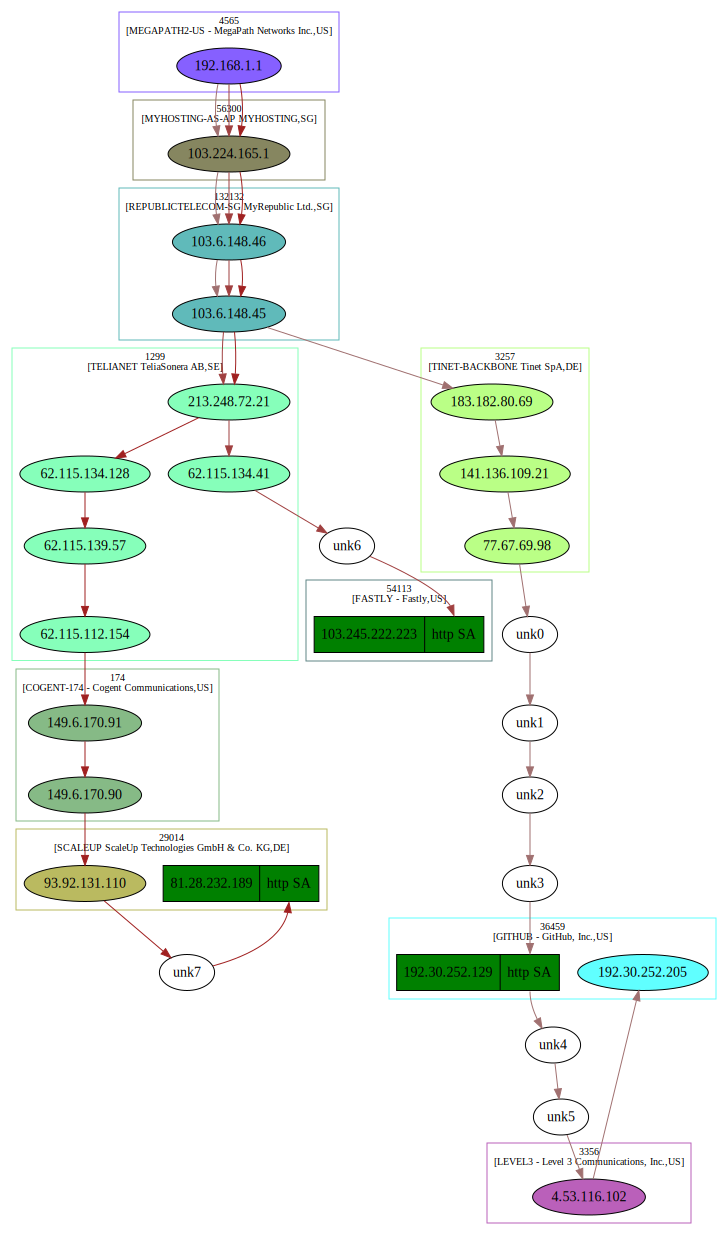

In [9]:
SVG(svg_file)

Graph doesn't show or gives an `ExpatError`?  Making a graph fails silently in IPython notebook when you don't have the necessary libraries installed (graphviz, imagemagick, and PyX).

We didn't install VPython, but if we did, we could view the above in 3D via `ans.trace3d()`  We also didn't install or PyX with LaTeX, which could give us nice PDFs or PNGs visuals of an individual packet.

Like a GUI better? or maybe just a lot going on?  Scapy can launch Wireshark for you!  It's just too simple -

In [ ]:
# will not work on tmpnb!

wireshark(dns_query)  # pass in any sort of packets 